In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from collections import Counter
from wordcloud import WordCloud # https://datascientest.com/wordcloud-python
from tqdm import tqdm
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.gridspec as gridspec
from scipy.stats import chi2_contingency
from scipy.special import kl_div

class RakutenExplorer:
    def __init__(self, X_train_path, y_train_path, image_folder):
        """Initialisation avec les chemins des fichiers"""
        self.X_train = pd.read_csv(X_train_path)
        self.y_train = pd.read_csv(y_train_path)
        self.image_folder = image_folder
        self.merged_data = pd.merge(self.X_train, self.y_train, left_index=True, right_index=True)
        
        # Vérification du dossier images
        if not os.path.exists(self.image_folder):
            raise ValueError(f"Le dossier d'images {self.image_folder} n'existe pas!")
        
    def basic_statistics(self):
        """Statistiques de base sur le dataset"""
        stats = {
            "Nombre total de produits": len(self.X_train),
            "Nombre de catégories uniques": len(self.y_train['prdtypecode'].unique()),
            "% de descriptions manquantes": (self.X_train['description'].isna().sum() / len(self.X_train)) * 100,
            "Longueur moyenne des désignations": self.X_train['designation'].str.len().mean(),
            "Nombre d'images uniques": len(set(self.X_train['imageid']))
        }
        return pd.Series(stats)

    def plot_category_distribution(self, figsize=(15, 8)):
        """Visualisation 1: Distribution des catégories"""
        plt.figure(figsize=figsize)
        category_counts = self.y_train['prdtypecode'].value_counts()
        
        sns.barplot(x=category_counts.values[:20], y=category_counts.index[:20])
        plt.title('Distribution des 20 catégories les plus fréquentes')
        plt.xlabel('Nombre de produits')
        plt.ylabel('Code catégorie')
        
        # Test statistique : Chi-square test for uniformity
        from scipy.stats import chisquare
        chi2_stat, p_value = chisquare(category_counts)
        print(f"Test Chi2 d'uniformité: p-value = {p_value}")
        
        return category_counts

    def analyze_text_length(self, figsize=(12, 6)):
        """Visualisation 2: Distribution des longueurs de texte"""
        plt.figure(figsize=figsize)
        
        designation_lengths = self.X_train['designation'].str.len()
        description_lengths = self.X_train['description'].dropna().str.len()
        
        plt.hist(designation_lengths, bins=50, alpha=0.5, label='Désignations')
        plt.hist(description_lengths, bins=50, alpha=0.5, label='Descriptions')
        plt.title('Distribution des longueurs de texte')
        plt.xlabel('Nombre de caractères')
        plt.ylabel('Fréquence')
        plt.legend()
        
        # Test statistique : Kolmogorov-Smirnov test
        from scipy.stats import ks_2samp
        ks_stat, p_value = ks_2samp(designation_lengths, description_lengths)
        print(f"Test KS entre désignations et descriptions: p-value = {p_value}")
        
        return designation_lengths.describe(), description_lengths.describe()

    def create_wordcloud_by_category(self, category_code, figsize=(12, 8)):
        """Visualisation 3: Nuage de mots par catégorie"""
        category_texts = self.merged_data[self.merged_data['prdtypecode'] == category_code]['designation']
        text = ' '.join(category_texts)
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        plt.figure(figsize=figsize)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Mots fréquents pour la catégorie {category_code}')
        
        # Analyse statistique des mots
        words = text.split()
        word_freq = Counter(words)
        return pd.Series(word_freq).sort_values(ascending=False).head(10)

    def analyze_image_properties(self, sample_size=1000):
        """Visualisation 4: Analyse des propriétés des images"""
        image_properties = []
        
        # Échantillonnage aléatoire pour l'analyse
        sampled_rows = self.X_train.sample(n=min(sample_size, len(self.X_train)))
        
        for _, row in tqdm(sampled_rows.iterrows(), total=len(sampled_rows)):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                with Image.open(image_path) as img:
                    properties = {
                        'height': img.size[1],
                        'width': img.size[0],
                        'aspect_ratio': img.size[0] / img.size[1],
                        'mean_brightness': np.mean(np.array(img.convert('L')))
                    }
                    image_properties.append(properties)
            except Exception as e:
                print(f"Erreur avec l'image {image_path}: {e}")
                continue
                
        df_properties = pd.DataFrame(image_properties)
        
        # Création des visualisations
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        sns.histplot(data=df_properties, x='width', ax=axes[0,0])
        axes[0,0].set_title('Distribution des largeurs')
        
        sns.histplot(data=df_properties, x='height', ax=axes[0,1])
        axes[0,1].set_title('Distribution des hauteurs')
        
        sns.scatterplot(data=df_properties, x='width', y='height', ax=axes[1,0])
        axes[1,0].set_title('Relation largeur/hauteur')
        
        sns.histplot(data=df_properties, x='mean_brightness', ax=axes[1,1])
        axes[1,1].set_title('Distribution de la luminosité moyenne')
        
        plt.tight_layout()
        
        return df_properties.describe()
    
    def analyze_image_dimensions(self, sample_size=None):
        """
        Analyse des dimensions d'images par classe avec tests statistiques
        
        Parameters:
        -----------
        sample_size : int or None
            Nombre d'images à analyser par classe. Si None, analyse toutes les images
        """
        # Collection des données
        print("Collecte des dimensions des images...")
        image_data = []
        
        # Préparation des données
        df = self.merged_data
        if sample_size:
            df = df.groupby('prdtypecode').apply(
                lambda x: x.sample(min(len(x), sample_size), random_state=42)
            ).reset_index(drop=True)
        
        for _, row in tqdm(df.iterrows()):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                with Image.open(image_path) as img:
                    image_data.append({
                        'category': row['prdtypecode'],
                        'width': img.size[0],
                        'height': img.size[1],
                        'aspect_ratio': img.size[0] / img.size[1],
                        'pixels': img.size[0] * img.size[1]
                    })
            except Exception as e:
                print(f"Erreur pour l'image {image_path}: {e}")
                continue
        
        # Création du DataFrame
        df_dims = pd.DataFrame(image_data)
        
        # Sélection des top catégories pour la lisibilité
        top_categories = df_dims['category'].value_counts().nlargest(10).index
        df_dims_filtered = df_dims[df_dims['category'].isin(top_categories)]
        
        # Création des visualisations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Boxplot des largeurs
        sns.boxplot(data=df_dims_filtered, x='category', y='width', ax=ax1)
        ax1.set_title('Distribution des largeurs par catégorie')
        ax1.set_xlabel('Catégorie')
        ax1.set_ylabel('Largeur (pixels)')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Boxplot des hauteurs
        sns.boxplot(data=df_dims_filtered, x='category', y='height', ax=ax2)
        ax2.set_title('Distribution des hauteurs par catégorie')
        ax2.set_xlabel('Catégorie')
        ax2.set_ylabel('Hauteur (pixels)')
        ax2.tick_params(axis='x', rotation=45)
        
        # 3. Boxplot des ratios d'aspect
        sns.boxplot(data=df_dims_filtered, x='category', y='aspect_ratio', ax=ax3)
        ax3.set_title('Distribution des ratios d\'aspect par catégorie')
        ax3.set_xlabel('Catégorie')
        ax3.set_ylabel('Ratio largeur/hauteur')
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Boxplot du nombre total de pixels
        sns.boxplot(data=df_dims_filtered, x='category', y='pixels', ax=ax4)
        ax4.set_title('Distribution du nombre de pixels par catégorie')
        ax4.set_xlabel('Catégorie')
        ax4.set_ylabel('Nombre total de pixels')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Tests statistiques
        print("\nTests statistiques:")
        
        # Test de normalité pour choisir entre ANOVA et Kruskal-Wallis
        from scipy import stats
        
        dimensions = ['width', 'height', 'aspect_ratio', 'pixels']
        test_results = {}
        
        for dim in dimensions:
            # Test de normalité (Shapiro-Wilk)
            _, p_norm = stats.shapiro(df_dims_filtered[dim])
            
            if p_norm < 0.05:  # Distribution non normale
                # Test de Kruskal-Wallis
                h_stat, p_value = stats.kruskal(*[
                    group[dim].values 
                    for name, group in df_dims_filtered.groupby('category')
                ])
                test_name = "Kruskal-Wallis"
            else:
                # ANOVA
                f_stat, p_value = stats.f_oneway(*[
                    group[dim].values 
                    for name, group in df_dims_filtered.groupby('category')
                ])
                test_name = "ANOVA"
            
            test_results[dim] = {
                'test': test_name,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
        
        # Affichage des résultats statistiques
        print("\nRésultats des tests statistiques:")
        for dim, results in test_results.items():
            print(f"\n{dim.capitalize()}:")
            print(f"Test utilisé: {results['test']}")
            print(f"p-value: {results['p_value']:.4f}")
            print(f"Différences significatives: {'Oui' if results['significant'] else 'Non'}")
        
        # Calcul des statistiques descriptives
        stats_desc = df_dims_filtered.groupby('category').agg({
            'width': ['mean', 'std', 'min', 'max'],
            'height': ['mean', 'std', 'min', 'max'],
            'aspect_ratio': ['mean', 'std', 'min', 'max'],
            'pixels': ['mean', 'std', 'min', 'max']
        })
        
        return {
            'test_results': test_results,
            'descriptive_stats': stats_desc,
            'raw_data': df_dims_filtered
        }
        
    def analyze_category_image_relationship(self, figsize=(12, 6)):
        """Visualisation 5: Relation entre catégories et propriétés des images"""
        image_properties = []
        
        for _, row in tqdm(self.merged_data.iterrows(), total=len(self.merged_data)):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                with Image.open(image_path) as img:
                    properties = {
                        'prdtypecode': row['prdtypecode'],  # Utiliser le même nom que dans les données
                        'mean_brightness': np.mean(np.array(img.convert('L'))),
                        'aspect_ratio': img.size[0] / img.size[1]
                    }
                    image_properties.append(properties)
            except Exception as e:
                continue
                    
        df_properties = pd.DataFrame(image_properties)
        
        # Limiter à top 10 catégories pour une meilleure lisibilité
        top_categories = self.merged_data['prdtypecode'].value_counts().nlargest(10).index
        df_plot = df_properties[df_properties['prdtypecode'].isin(top_categories)]
        
        plt.figure(figsize=figsize)
        sns.boxplot(x='prdtypecode', y='mean_brightness', data=df_plot)
        plt.xticks(rotation=45)
        plt.title('Distribution de la luminosité par catégorie (Top 10)')
        
        # Test statistique : ANOVA
        categories = df_properties['prdtypecode'].unique()
        brightness_by_category = [
            df_properties[df_properties['prdtypecode'] == cat]['mean_brightness'] 
            for cat in categories
        ]
        f_stat, p_value = f_oneway(*brightness_by_category)
        print(f"ANOVA test pour la luminosité entre catégories: p-value = {p_value}")
        
        return df_properties.groupby('prdtypecode')['mean_brightness'].describe()
     
    class ColorAnalyzer:
        def __init__(self, n_colors=8):
            """
            n_colors: nombre de clusters de couleurs à identifier
            """
            self.n_colors = n_colors
            self.kmeans = KMeans(n_clusters=self.n_colors, random_state=42)
            
        def extract_dominant_colors(self, image_path):
            """Extrait les n_colors couleurs dominantes d'une image"""
            try:
                img = Image.open(image_path)
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # Redimensionner pour optimiser le traitement
                img = img.resize((150, 150))
                pixels = np.float32(img).reshape(-1, 3)
                
                # Appliquer K-means avec n_colors clusters
                self.kmeans.fit(pixels)
                colors = self.kmeans.cluster_centers_.astype(int)
                labels = self.kmeans.labels_
                
                # Calculer les proportions
                unique_labels, counts = np.unique(labels, return_counts=True)
                percentages = counts / len(labels)
                
                # Trier par pourcentage décroissant
                color_percentages = sorted(zip(colors, percentages), 
                                        key=lambda x: x[1], 
                                        reverse=True)
                
                return color_percentages
                
            except Exception as e:
                print(f"Erreur lors du traitement de {image_path}: {e}")
                return None

    def analyze_color_distributions_old(self, sample_size=200, n_top_colors=8):
        """
        Analyse de la distribution des couleurs dominantes
        
        Parameters:
        -----------
        sample_size : int
            Nombre d'images à analyser par catégorie
        n_top_colors : int
            Nombre de couleurs dominantes à identifier
        """
        sampled_data = self.merged_data.groupby('prdtypecode').apply(
            lambda x: x.sample(min(len(x), sample_size), random_state=42)
        ).reset_index(drop=True)
        
        # Initialiser l'analyseur de couleurs
        analyzer = self.ColorAnalyzer(n_colors=n_top_colors)
        
        # Collecter toutes les couleurs avec leur compte
        print("Extraction des couleurs dominantes...")
        color_counts = defaultdict(int)
        total_images = 0
        
        for _, row in tqdm(sampled_data.iterrows()):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            colors = analyzer.extract_dominant_colors(image_path)
            if colors:
                total_images += 1
                # Prendre la couleur la plus dominante de chaque image
                main_color = tuple(colors[0][0])  # Première couleur (la plus dominante)
                color_counts[main_color] += 1
        
        # Calculer les pourcentages
        color_percentages = {
            color: (count / total_images) * 100 
            for color, count in color_counts.items()
        }
        
        # Prendre les n_top_colors couleurs les plus fréquentes
        top_colors = sorted(
            color_percentages.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:n_top_colors]
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        
        # Préparer les données pour le pie chart
        hex_colors = ['#{:02x}{:02x}{:02x}'.format(*color) for color, _ in top_colors]
        sizes = [pct for _, pct in top_colors]
        labels = [f'RGB({",".join(map(str, color))})' for color, _ in top_colors]
        
        # Créer le pie chart
        patches, texts, autotexts = plt.pie(sizes, 
                                        labels=labels,
                                        colors=hex_colors,
                                        autopct='%1.1f%%',
                                        startangle=90)
        
        # Améliorer la lisibilité
        plt.setp(autotexts, size=8, weight='bold')
        plt.setp(texts, size=8)
        
        plt.title(f'Distribution des {n_top_colors} couleurs dominantes dans le dataset')
        plt.axis('equal')
        
        # Légende avec format propre
        legend_labels = [
            f'Couleur {i+1}: RGB({",".join(map(str, color))}) ({pct:.1f}%)' 
            for i, (color, pct) in enumerate(top_colors)
        ]
        
        plt.legend(patches, 
                legend_labels,
                title="Couleurs dominantes",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nNombre total d'images analysées : {total_images}")
        print("\nPourcentages des couleurs dominantes :")
        for color, pct in top_colors:
            print(f"RGB({','.join(map(str, color))}): {pct:.1f}%")
        
        top_categories = self.merged_data['prdtypecode'].value_counts().nlargest(6).index
        contingency_matrix = []
                
        print(f"\nAnalyse des {len(top_categories)} catégories principales...")
        
        # Créer une matrice 2D (catégories x couleurs)
        for category in top_categories:
            category_colors = [0] * n_top_colors  # Une ligne par catégorie
            if category in category_colors:
                for i, (color, _) in enumerate(top_colors):
                    # Compter la fréquence de chaque couleur dans cette catégorie
                    category_colors[i] = sum(1 for c in category_colors[category] if np.array_equal(c[0], color))
            contingency_matrix.append(category_colors)
        
        # Convertir en array numpy
        contingency_matrix = np.array(contingency_matrix)
        
        # Assurer des valeurs non négatives
        contingency_matrix = np.clip(contingency_matrix, 0, None)
        
        # Normaliser les lignes
        row_sums = contingency_matrix.sum(axis=1, keepdims=True)
        if not np.any(row_sums == 0):  # Éviter la division par zéro
            contingency_matrix = contingency_matrix / row_sums
        
        # Test du chi2
        chi2_stat, p_value, dof, expected = chi2_contingency(contingency_matrix)
        print("\nRésultats du test Chi2:")
        print(f"Statistique: {chi2_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Degrés de liberté: {dof}")
        
        # Calcul des divergences KL
        kl_divergences = {}
        for i, cat1 in enumerate(top_categories):
            for j, cat2 in enumerate(top_categories):
                if i < j:
                    dist1 = contingency_matrix[i]
                    dist2 = contingency_matrix[j]
                    
                    # Éviter la division par zéro
                    dist1 = np.clip(dist1, 1e-10, 1)
                    dist2 = np.clip(dist2, 1e-10, 1)
                    
                    # Normaliser
                    dist1 = dist1 / dist1.sum()
                    dist2 = dist2 / dist2.sum()
                    
                    kl = np.sum(kl_div(dist1, dist2))
                    kl_divergences[f"{cat1}-{cat2}"] = kl
        
        print("\nDivergences KL entre catégories:")
        for pair, div in sorted(kl_divergences.items(), key=lambda x: x[1], reverse=True):
            print(f"{pair}: {div:.4f}")


        return {
            'colors': colors,
            'percentages': sizes,
            'raw_data': dict(zip(colors, sizes)),
            'chi2_results': {
                'statistic': chi2_stat,
                'p_value': p_value,
                'dof': dof
            },
            'kl_divergences': kl_divergences
        }
    
    def analyze_color_distributions(self, sample_size=200, n_top_colors=8):
        """Analyse de la distribution des couleurs dominantes en excluant le blanc"""
        
        def is_white_or_near_white(color, threshold=250):
            """Vérifie si une couleur est blanche ou presque blanche"""
            return all(c > threshold for c in color)
        
        # Échantillonnage stratifié
        sampled_data = self.merged_data.groupby('prdtypecode').apply(
            lambda x: x.sample(min(len(x), sample_size), random_state=42)
        ).reset_index(drop=True)
        
        # Initialiser l'analyseur de couleurs
        analyzer = self.ColorAnalyzer(n_colors=n_top_colors)
        
        # Collecter toutes les couleurs avec leur compte
        print("Extraction des couleurs dominantes...")
        color_counts = defaultdict(int)
        total_images = 0
        
        for _, row in tqdm(sampled_data.iterrows()):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            colors = analyzer.extract_dominant_colors(image_path)
            if colors:
                total_images += 1
                # Trouver la première couleur non-blanche
                for color, _ in colors:
                    if not is_white_or_near_white(color):
                        color_counts[tuple(map(int, color))] += 1
                        break
                else:  # Si toutes les couleurs sont blanches
                    color_counts[tuple(map(int, colors[0][0]))] += 1
        
        # Calculer les pourcentages
        color_percentages = {
            color: (count / total_images) * 100 
            for color, count in color_counts.items()
        }
        
        # Prendre les n_top_colors couleurs les plus fréquentes
        top_colors = sorted(
            color_percentages.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:n_top_colors]
        
        # Visualisation
        plt.figure(figsize=(12, 8))
        
        # Préparer les données pour le pie chart
        hex_colors = [f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}' for color, _ in top_colors]
        sizes = [pct for _, pct in top_colors]
        labels = [f'RGB({",".join(map(str, color))})' for color, _ in top_colors]
        
        # Créer le pie chart
        patches, texts, autotexts = plt.pie(sizes, 
                                        labels=labels,
                                        colors=hex_colors,
                                        autopct='%1.1f%%',
                                        startangle=90)
        
        # Améliorer la lisibilité
        plt.setp(autotexts, size=8, weight='bold')
        plt.setp(texts, size=8)
        
        plt.title(f'Distribution des {n_top_colors} couleurs dominantes dans le dataset')
        plt.axis('equal')
        
        # Légende avec format propre
        legend_labels = [
            f'Couleur {i+1}: RGB({",".join(map(str, color))}) ({pct:.1f}%)' 
            for i, (color, pct) in enumerate(top_colors)
        ]
        
        plt.legend(patches, 
                legend_labels,
                title="Couleurs dominantes",
                loc="center left",
                bbox_to_anchor=(1, 0, 0.5, 1))
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nNombre total d'images analysées : {total_images}")
        print("\nPourcentages des couleurs dominantes :")
        for color, pct in top_colors:
            print(f"RGB({','.join(map(str, color))}): {pct:.1f}%")
        
        # Construction de la matrice de contingence pour les tests statistiques
        categories = sampled_data['prdtypecode'].value_counts().nlargest(6).index
        contingency_matrix = np.zeros((len(categories), len(top_colors)))
        
        for i, category in enumerate(categories):
            category_images = sampled_data[sampled_data['prdtypecode'] == category].index
            for j, (color, _) in enumerate(top_colors):
                count = sum(1 for idx in category_images if tuple(map(int, analyzer.extract_dominant_colors(
                    os.path.join(self.image_folder, f"image_{sampled_data.loc[idx, 'imageid']}_product_{sampled_data.loc[idx, 'productid']}.jpg")
                )[0][0])) == color)
                contingency_matrix[i, j] = count
        
        # Tests statistiques
        try:
            chi2_stat, p_value, dof, expected = chi2_contingency(contingency_matrix)
            print("\nRésultats du test Chi2:")
            print(f"Statistique: {chi2_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            print(f"Degrés de liberté: {dof}")
        except:
            print("\nImpossible de réaliser le test Chi2")
        
        return {
            'colors': hex_colors,
            'percentages': sizes,
            'counts': dict(color_counts)
        }
    
    def analyze_image_quality_old(self, sample_size=None):
        """
        Analyse de la qualité des images basée sur la taille des fichiers par classe
        
        Parameters:
        -----------
        sample_size : int or None
            Nombre d'images à analyser par classe. Si None, analyse toutes les images
        """
        print("Analyse de la qualité des images...")
        image_data = []
        
        # Préparation des données
        df = self.merged_data
        if sample_size:
            df = df.groupby('prdtypecode').apply(
                lambda x: x.sample(min(len(x), sample_size), random_state=42)
            ).reset_index(drop=True)
        
        for _, row in tqdm(df.iterrows()):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                # Obtenir la taille du fichier en KB
                file_size = os.path.getsize(image_path) / 1024
                
                # Obtenir les dimensions pour calculer la densité (KB/pixel)
                with Image.open(image_path) as img:
                    width, height = img.size
                    pixels = width * height
                    density = file_size / pixels * 1e6  # en KB/million de pixels
                
                image_data.append({
                    'category': row['prdtypecode'],
                    'file_size': file_size,
                    'pixels': pixels,
                    'density': density
                })
            except Exception as e:
                print(f"Erreur pour l'image {image_path}: {e}")
                continue
        
        # Création du DataFrame
        df_quality = pd.DataFrame(image_data)
        
        # Sélection des top catégories pour la lisibilité
        top_categories = df_quality['category'].value_counts().nlargest(10).index
        df_filtered = df_quality[df_quality['category'].isin(top_categories)]
        
        # Création des visualisations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Boxplot des tailles de fichiers
        sns.boxplot(data=df_filtered, x='category', y='file_size', ax=ax1)
        ax1.set_title('Distribution des tailles de fichiers par catégorie')
        ax1.set_xlabel('Catégorie')
        ax1.set_ylabel('Taille (KB)')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Scatter plot taille vs pixels
        sns.scatterplot(data=df_filtered, x='pixels', y='file_size', 
                    hue='category', alpha=0.6, ax=ax2)
        ax2.set_title('Taille fichier vs Nombre de pixels')
        ax2.set_xlabel('Nombre de pixels')
        ax2.set_ylabel('Taille (KB)')
        
        # 3. Boxplot des densités
        sns.boxplot(data=df_filtered, x='category', y='density', ax=ax3)
        ax3.set_title('Distribution des densités par catégorie')
        ax3.set_xlabel('Catégorie')
        ax3.set_ylabel('Densité (KB/million pixels)')
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Histogramme des tailles de fichiers
        sns.histplot(data=df_filtered, x='file_size', hue='category', 
                    multiple="stack", bins=30, ax=ax4)
        ax4.set_title('Distribution des tailles de fichiers')
        ax4.set_xlabel('Taille (KB)')
        ax4.set_ylabel('Nombre d\'images')
        
        plt.tight_layout()
        plt.show()
        
        # Tests statistiques
        print("\nTests statistiques sur la qualité des images:")
        
        from scipy import stats
        
        # Test de Kruskal-Wallis pour la taille des fichiers
        h_stat, p_value = stats.kruskal(*[
            group['file_size'].values 
            for name, group in df_filtered.groupby('category')
        ])
        
        print("\nTest Kruskal-Wallis sur les tailles de fichiers:")
        print(f"H-statistic: {h_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        
        # Statistiques descriptives par catégorie
        stats_desc = df_filtered.groupby('category').agg({
            'file_size': ['count', 'mean', 'std', 'min', 'max'],
            'density': ['mean', 'std', 'min', 'max']
        }).round(2)
        
        print("\nStatistiques descriptives par catégorie:")
        print(stats_desc)
        
        # Identifier les potentiels problèmes de qualité
        low_quality_threshold = df_filtered['density'].quantile(0.25)
        high_quality_threshold = df_filtered['density'].quantile(0.75)
        
        quality_issues = {
            'low_quality': df_filtered[df_filtered['density'] < low_quality_threshold].shape[0],
            'high_quality': df_filtered[df_filtered['density'] > high_quality_threshold].shape[0],
            'total_images': len(df_filtered)
        }
        
        print("\nAnalyse de la qualité:")
        print(f"Images de basse qualité (< {low_quality_threshold:.2f} KB/MP): {quality_issues['low_quality']}")
        print(f"Images de haute qualité (> {high_quality_threshold:.2f} KB/MP): {quality_issues['high_quality']}")
        
        return {
            'descriptive_stats': stats_desc,
            'quality_issues': quality_issues,
            'raw_data': df_filtered
        }
        
    def analyze_image_quality(self, sample_size=None):
        """
        Analyse de la qualité des images basée sur la taille des fichiers par classe
        """
        print("Analyse de la qualité des images...")
        image_data = []
        
        # Préparation des données
        df = self.merged_data
        if sample_size:
            df = df.groupby('prdtypecode').apply(
                lambda x: x.sample(min(len(x), sample_size), random_state=42)
            ).reset_index(drop=True)
        
        for _, row in tqdm(df.iterrows()):
            image_path = os.path.join(
                self.image_folder,
                f"image_{row['imageid']}_product_{row['productid']}.jpg"
            )
            try:
                # Taille du fichier en KB
                file_size = os.path.getsize(image_path) / 1024
                
                with Image.open(image_path) as img:
                    width, height = img.size
                    pixels = width * height
                    density = file_size / pixels * 1e6  # KB/million de pixels
                    
                    # Calcul de la qualité moyenne
                    img_array = np.array(img)
                    if len(img_array.shape) == 3:  # Image couleur
                        quality = np.mean(img_array.std(axis=(0,1)))  # Variation des couleurs
                    else:
                        quality = img_array.std()  # Variation des niveaux de gris
                
                image_data.append({
                    'category': row['prdtypecode'],
                    'file_size': file_size,
                    'pixels': pixels,
                    'density': density,
                    'quality_score': quality,
                    'resolution': f"{width}x{height}"
                })
            except Exception as e:
                print(f"Erreur pour l'image {image_path}: {e}")
                continue
        
        df_quality = pd.DataFrame(image_data)
        
        # Sélection des top catégories
        top_categories = df_quality['category'].value_counts().nlargest(10).index
        df_filtered = df_quality[df_quality['category'].isin(top_categories)]
        
        # Visualisations
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Boxplot des tailles de fichiers
        sns.boxplot(data=df_filtered, x='category', y='file_size', ax=ax1)
        ax1.set_title('Distribution des tailles de fichiers par catégorie')
        ax1.set_xlabel('Catégorie')
        ax1.set_ylabel('Taille (KB)')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. Relation taille fichier vs nombre de pixels
        g = sns.scatterplot(data=df_filtered, 
                        x='pixels', 
                        y='file_size',
                        hue='category',
                        alpha=0.6,
                        ax=ax2)
        ax2.set_title('Taille fichier vs Nombre de pixels')
        ax2.set_xlabel('Nombre de pixels')
        ax2.set_ylabel('Taille (KB)')
        g.legend_.remove()  # Enlever la légende pour plus de clarté
        
        # 3. Distribution des scores de qualité
        sns.violinplot(data=df_filtered, 
                    x='category', 
                    y='quality_score',
                    ax=ax3)
        ax3.set_title('Distribution des scores de qualité par catégorie')
        ax3.set_xlabel('Catégorie')
        ax3.set_ylabel('Score de qualité')
        ax3.tick_params(axis='x', rotation=45)
        
        # 4. Distribution des ratios de compression
        compression_ratio = df_filtered['pixels'] / df_filtered['file_size']
        df_filtered['compression_ratio'] = compression_ratio
        sns.boxplot(data=df_filtered, 
                    x='category', 
                    y='compression_ratio',
                    ax=ax4)
        ax4.set_title('Ratio de compression par catégorie')
        ax4.set_xlabel('Catégorie')
        ax4.set_ylabel('Ratio pixels/KB')
        ax4.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Statistiques descriptives
        print("\nStatistiques par catégorie:")
        stats = df_filtered.groupby('category').agg({
            'file_size': ['count', 'mean', 'std', 'min', 'max'],
            'quality_score': ['mean', 'std'],
            'compression_ratio': ['mean', 'std']
        }).round(2)
        print(stats)
        
        # Tests statistiques
        from scipy import stats
        
        # Test Kruskal-Wallis sur les tailles de fichiers
        h_stat_size, p_value_size = stats.kruskal(*[
            group['file_size'].values 
            for _, group in df_filtered.groupby('category')
        ])
        
        # Test Kruskal-Wallis sur les scores de qualité
        h_stat_quality, p_value_quality = stats.kruskal(*[
            group['quality_score'].values 
            for _, group in df_filtered.groupby('category')
        ])
        
        print("\nTests statistiques:")
        print(f"Kruskal-Wallis sur les tailles: p-value = {p_value_size:.4f}")
        print(f"Kruskal-Wallis sur la qualité: p-value = {p_value_quality:.4f}")
        
        return {
            'descriptive_stats': stats,
            'test_results': {
                'size_test': {'statistic': h_stat_size, 'p_value': p_value_size},
                'quality_test': {'statistic': h_stat_quality, 'p_value': p_value_quality}
            },
            'raw_data': df_filtered
        }

explorer = RakutenExplorer(
    X_train_path='Raw_data/X_train_update.csv',
    y_train_path='Raw_data/Y_train_CVw08PX.csv',
    image_folder='Raw_data/images/image_train'
)



Statistiques de base:
Nombre total de produits             84916.000000
Nombre de catégories uniques            27.000000
% de descriptions manquantes            35.093504
Longueur moyenne des désignations       70.163303
Nombre d'images uniques              84916.000000
dtype: float64

Analyse de la distribution des catégories:
Test Chi2 d'uniformité: p-value = 0.0


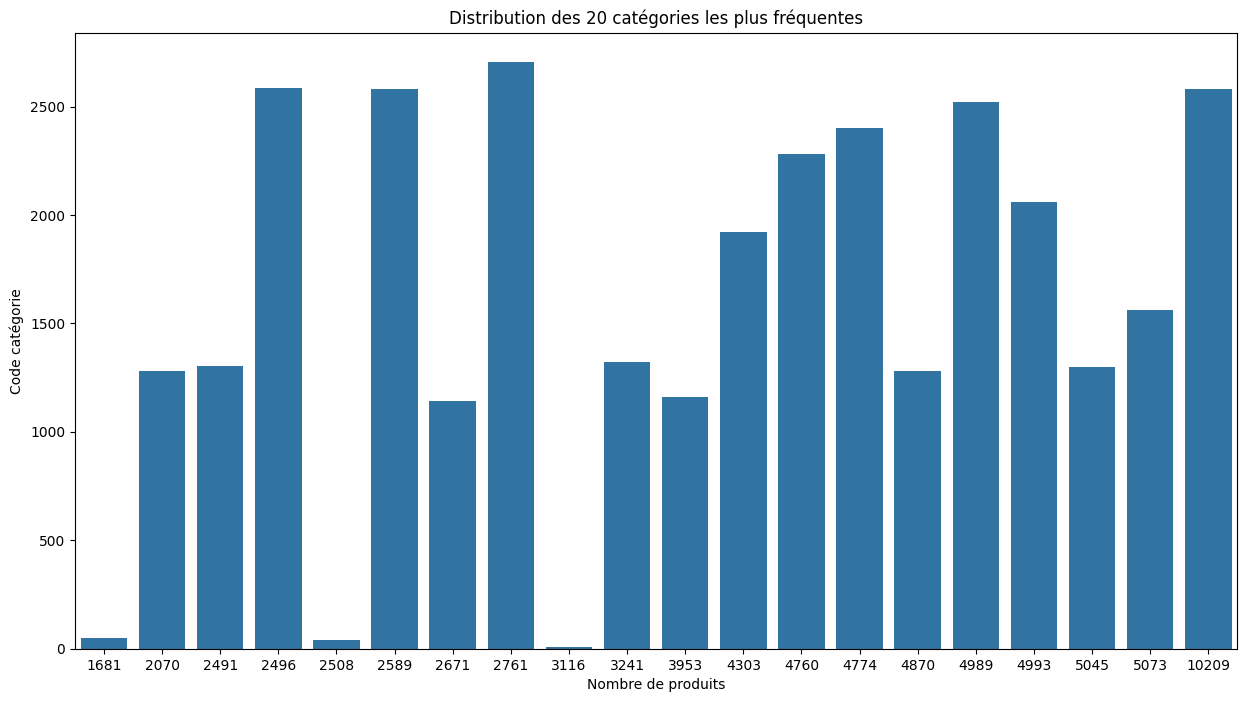


Analyse des longueurs de texte:
Test KS entre désignations et descriptions: p-value = 0.0


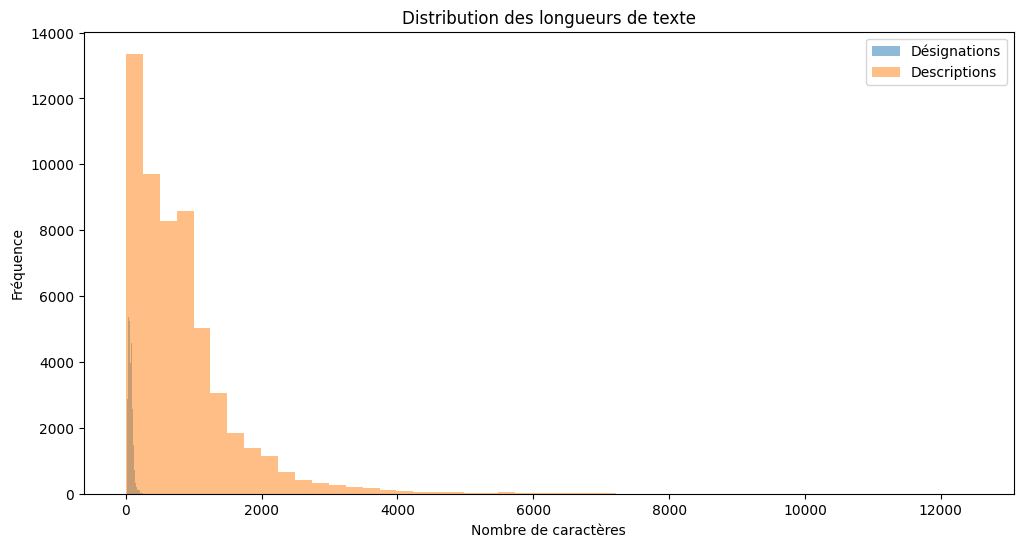


Analyse des mots fréquents:


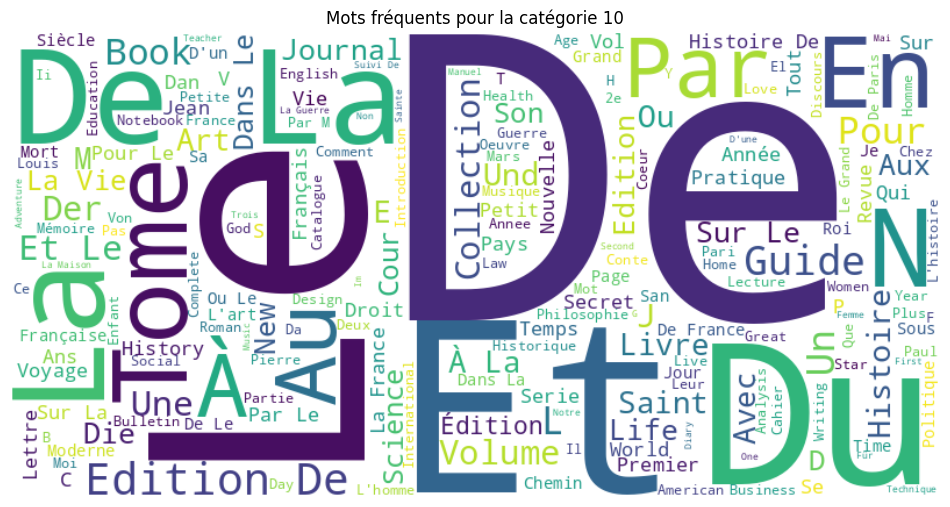


Analyse des propriétés des images:


100%|██████████| 1000/1000 [00:04<00:00, 225.50it/s]


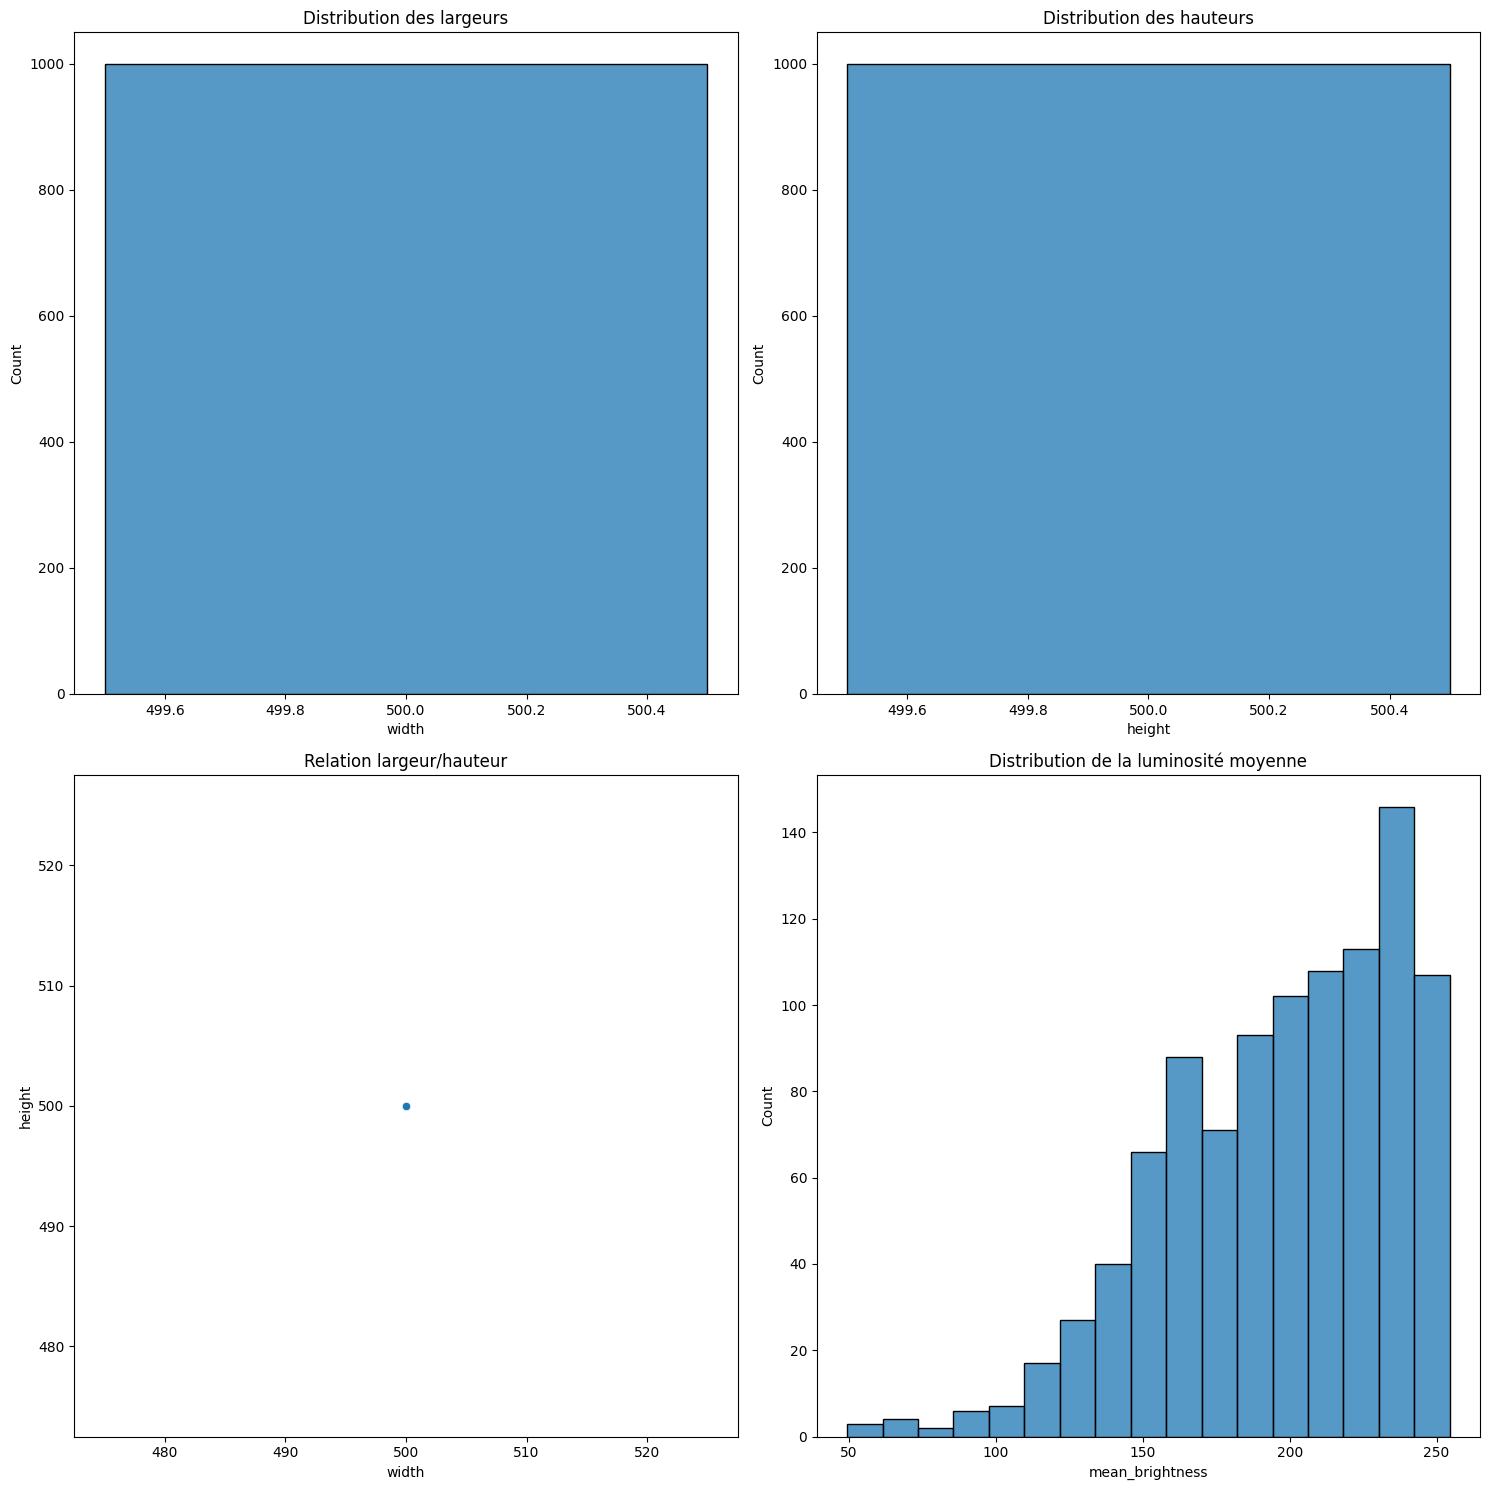

In [ ]:
# Statistiques de base
print("\nStatistiques de base:")
print(explorer.basic_statistics())

# Distribution des catégories
print("\nAnalyse de la distribution des catégories:")
explorer.plot_category_distribution()
plt.show()

# Analyse des textes
print("\nAnalyse des longueurs de texte:")
explorer.analyze_text_length()
plt.show()

# Nuage de mots pour une catégorie
print("\nAnalyse des mots fréquents:")
explorer.create_wordcloud_by_category(category_code=10)
plt.show()

# Analyse des images
print("\nAnalyse des propriétés des images:")
explorer.analyze_image_properties()
plt.show()



Analyse de la relation entre catégories et images:


100%|██████████| 84916/84916 [05:39<00:00, 250.18it/s]


ANOVA test pour la luminosité entre catégories: p-value = 0.0


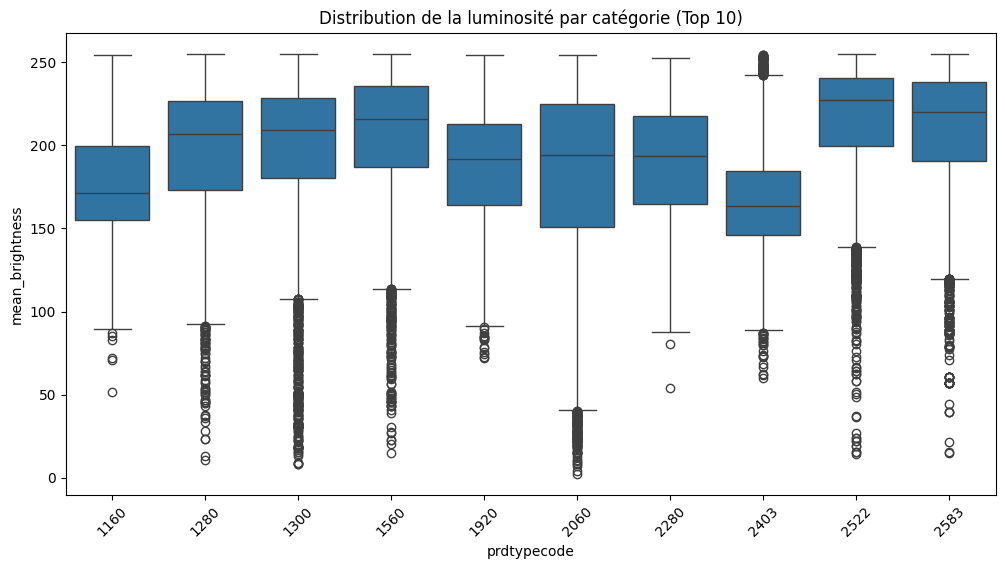

In [2]:
# Relation catégories-images
print("\nAnalyse de la relation entre catégories et images:")
explorer.analyze_category_image_relationship()
plt.show()

/tmp/ipykernel_950/3809005490.py:223: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = self.merged_data.groupby('prdtypecode').apply(


Analyse des couleurs dominantes...


 62%|██████▏   | 1678/2700 [00:35<00:22, 44.54it/s]/home/elion/Dev_IA/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 2700/2700 [00:57<00:00, 47.36it/s]


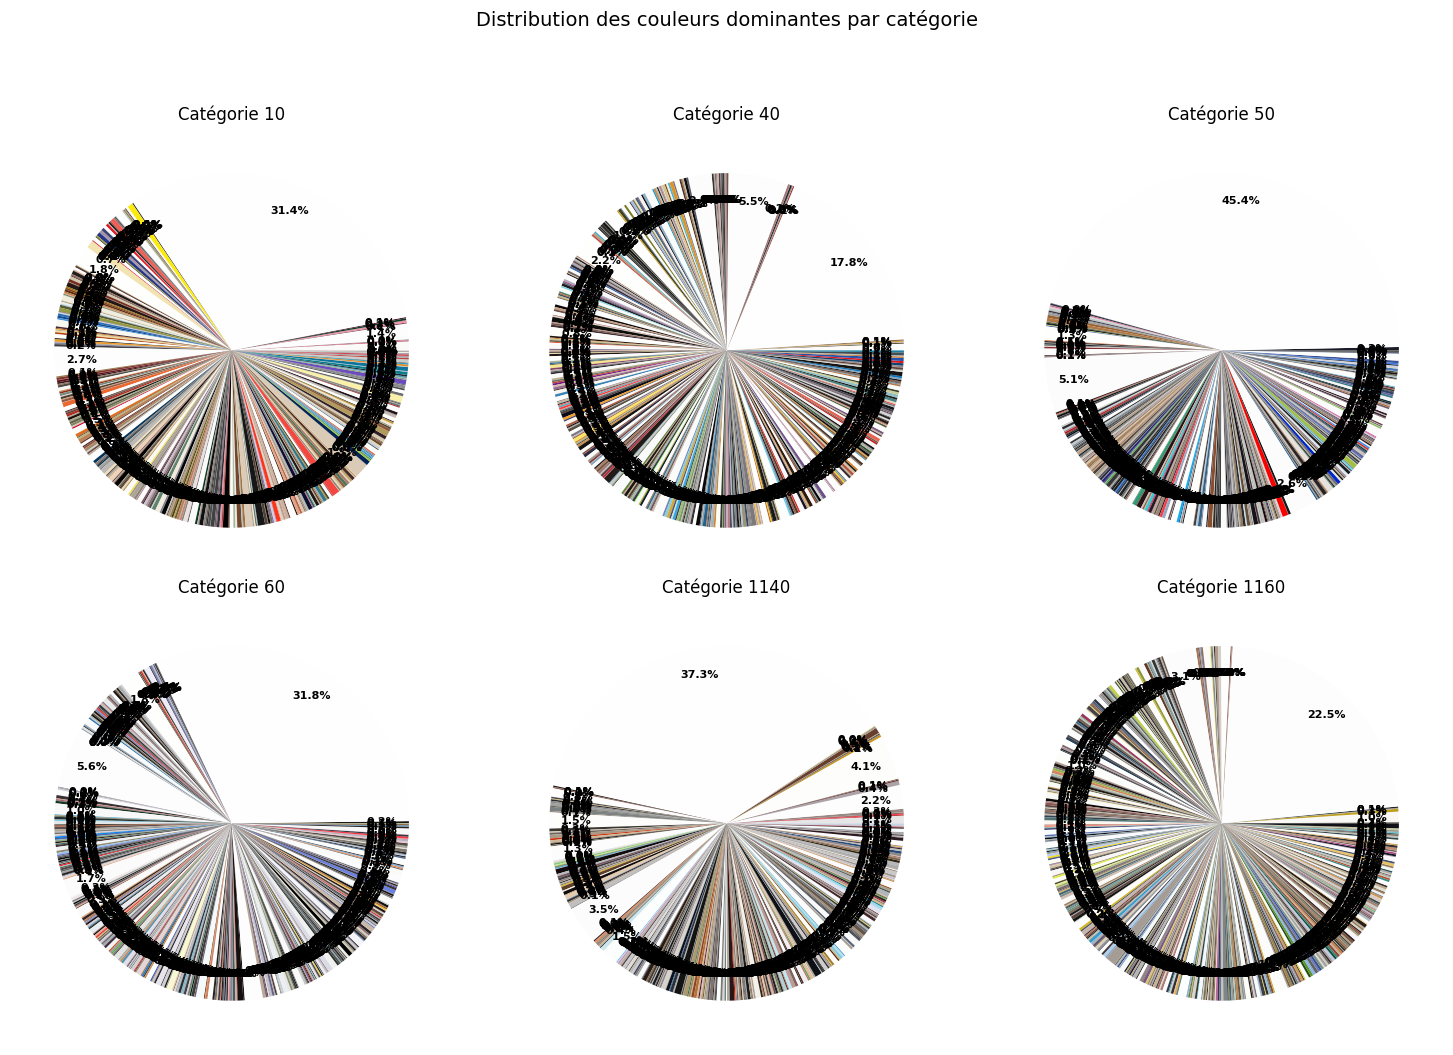

In [ ]:

def get_dominant_colors(image_path, n_colors=5):
    """Extrait les couleurs dominantes d'une image avec K-means"""
    try:
        # Charger l'image
        img = Image.open(image_path)
        # Convertir en RGB si nécessaire
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Redimensionner pour accélérer le traitement
        img = img.resize((150, 150))
        
        # Convertir en array et reshape pour K-means
        pixels = np.float32(img).reshape(-1, 3)
        
        # Appliquer K-means
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(pixels)
        
        # Obtenir les couleurs et leurs proportions
        colors = kmeans.cluster_centers_
        labels = kmeans.labels_
        
        # Calculer les proportions de chaque couleur
        unique_labels, counts = np.unique(labels, return_counts=True)
        percentages = counts / len(labels)
        
        # Convertir les couleurs en format RGB (0-255)
        colors = colors.astype(int)
        
        return list(zip(colors, percentages))
        
    except Exception as e:
        print(f"Erreur pour {image_path}: {e}")
        return None

def analyze_colors_by_category(self, sample_size=100, n_colors=5):
    """Analyse les couleurs dominantes par catégorie"""
    # Dictionnaire pour stocker les résultats par catégorie
    category_colors = defaultdict(list)
    
    # Échantillonnage stratifié par catégorie
    sampled_data = self.merged_data.groupby('prdtypecode').apply(
        lambda x: x.sample(min(len(x), sample_size), random_state=42)
    ).reset_index(drop=True)
    
    print("Analyse des couleurs dominantes...")
    for _, row in tqdm(sampled_data.iterrows(), total=len(sampled_data)):
        image_path = os.path.join(
            self.image_folder,
            f"image_{row['imageid']}_product_{row['productid']}.jpg"
        )
        
        colors = get_dominant_colors(image_path, n_colors=n_colors)
        if colors:
            category_colors[row['prdtypecode']].append(colors)
    
    # Calculer les moyennes des proportions par catégorie
    category_color_averages = {}
    for category, color_lists in category_colors.items():
        # Initialiser les accumulateurs
        color_sums = defaultdict(lambda: [0, 0, 0])
        color_counts = defaultdict(int)
        
        # Accumuler les couleurs similaires
        for image_colors in color_lists:
            for color, percentage in image_colors:
                # Convertir en tuple pour utiliser comme clé
                color_key = tuple(color)
                color_sums[color_key] = [
                    s + c * percentage for s, c in zip(color_sums[color_key], color)
                ]
                color_counts[color_key] += percentage
        
        # Calculer les moyennes
        averaged_colors = []
        for color_key, sums in color_sums.items():
            count = color_counts[color_key]
            if count > 0:
                avg_color = [int(s / count) for s in sums]
                averaged_colors.append((avg_color, count / len(color_lists)))
        
        category_color_averages[category] = averaged_colors
    
    # Visualisation
    # Sélectionner les top catégories les plus fréquentes
    top_categories = sampled_data['prdtypecode'].value_counts().nlargest(6).index
    
    # Créer un subplot pour chaque catégorie
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 3)
    
    for idx, category in enumerate(top_categories):
        ax = plt.subplot(gs[idx // 3, idx % 3])
        
        colors = category_color_averages[category]
        if colors:
            # Extraire les couleurs et proportions
            pie_colors = ['#{:02x}{:02x}{:02x}'.format(*c[0]) for c in colors]
            proportions = [c[1] for c in colors]
            
            # Créer le pie chart
            wedges, texts, autotexts = ax.pie(
                proportions,
                colors=pie_colors,
                autopct='%1.1f%%',
                pctdistance=0.85
            )
            
            # Améliorer la lisibilité des pourcentages
            plt.setp(autotexts, size=8, weight="bold")
            
            ax.set_title(f'Catégorie {category}')
    
    plt.suptitle('Distribution des couleurs dominantes pour les 6 catégories les plus représentées', size=14, y=1.05)
    plt.tight_layout()
    
    return category_color_averages

color_analysis = explorer.analyze_colors_by_category(sample_size=100, n_colors=5)

/tmp/ipykernel_950/2909380912.py:523: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_data = self.merged_data.groupby('prdtypecode').apply(


Extraction des couleurs dominantes...


3281it [01:34, 32.66it/s]/home/elion/Dev_IA/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
5400it [02:33, 35.09it/s]


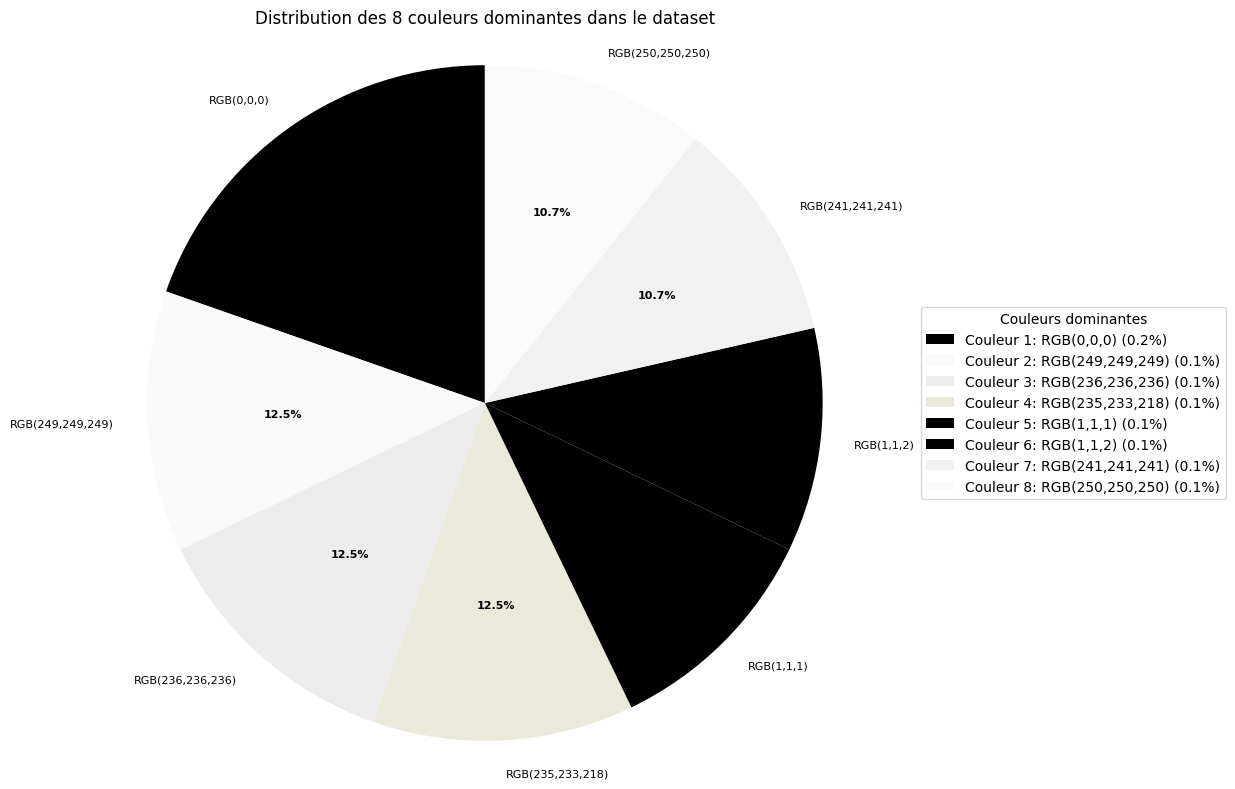


Nombre total d'images analysées : 5400

Pourcentages des couleurs dominantes :
RGB(0,0,0): 0.2%
RGB(249,249,249): 0.1%
RGB(236,236,236): 0.1%
RGB(235,233,218): 0.1%
RGB(1,1,1): 0.1%
RGB(1,1,2): 0.1%
RGB(241,241,241): 0.1%
RGB(250,250,250): 0.1%

Impossible de réaliser le test Chi2


In [55]:

results = explorer.analyze_color_distributions(sample_size=200)    

/tmp/ipykernel_950/891150041.py:653: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('prdtypecode').apply(


Analyse de la qualité des images...


0it [00:00, ?it/s]

5400it [01:37, 55.15it/s]
/tmp/ipykernel_950/891150041.py:730: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['compression_ratio'] = compression_ratio


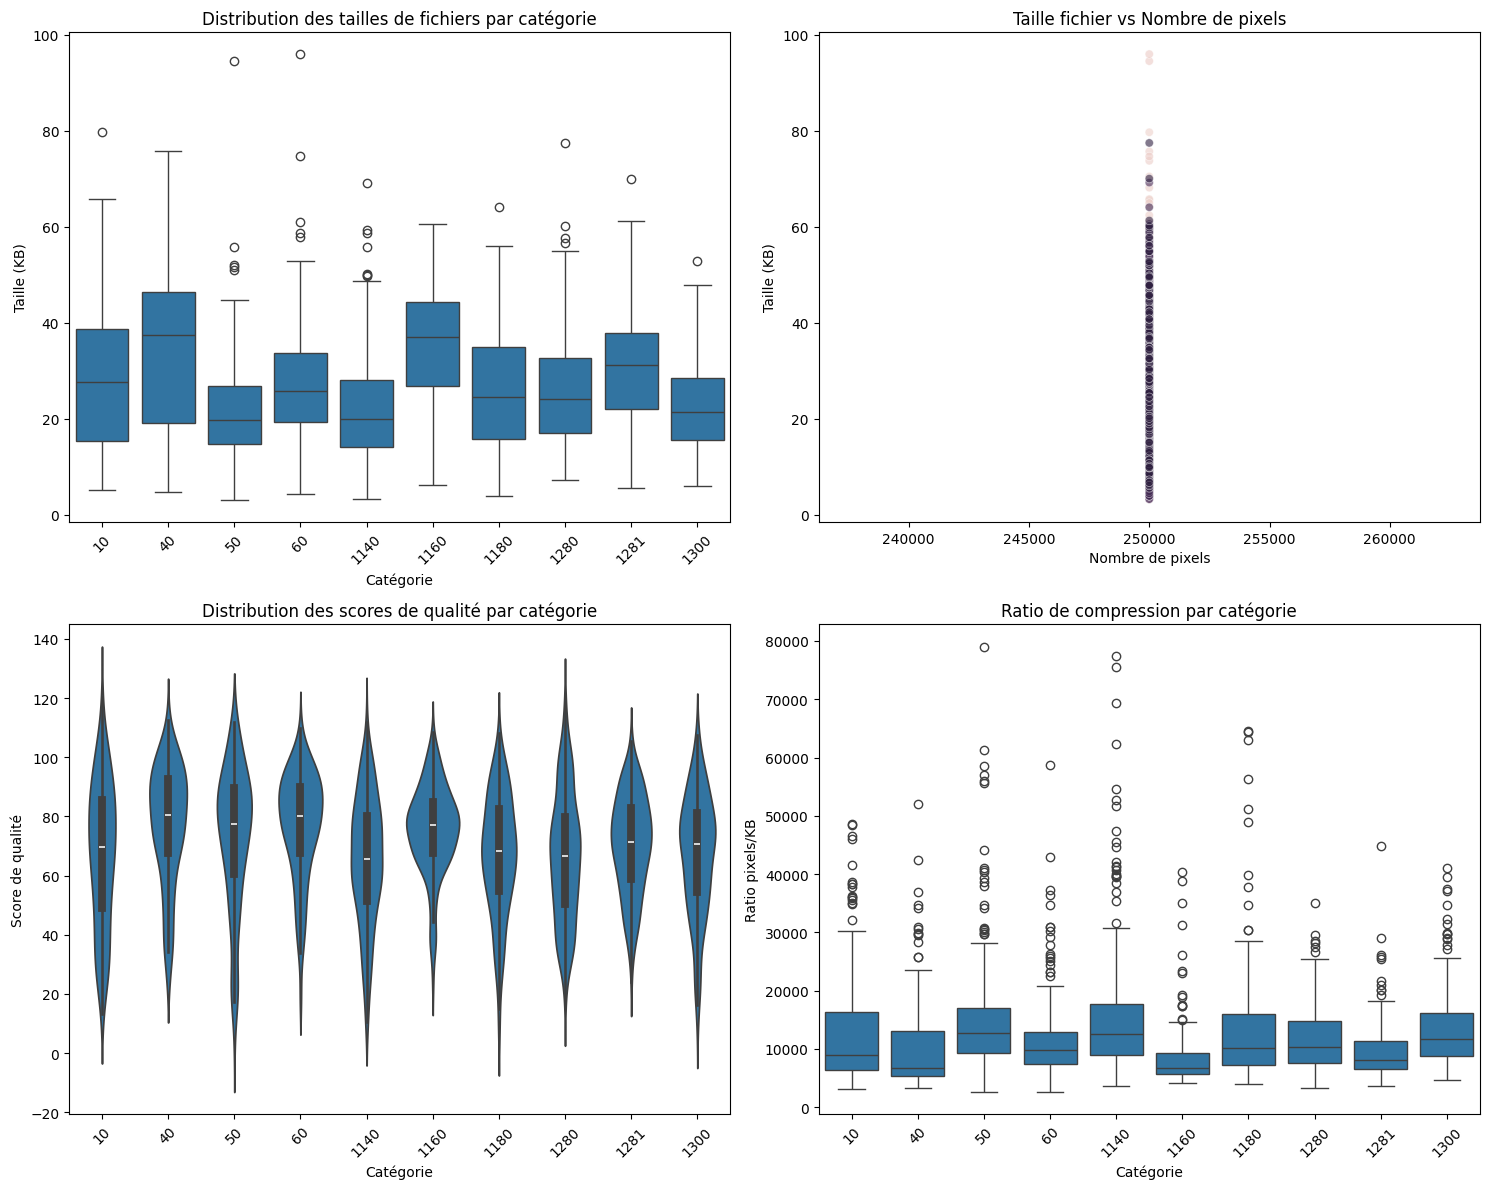


Statistiques par catégorie:
         file_size                            quality_score         \
             count   mean    std   min    max          mean    std   
category                                                             
10             200  28.41  15.08  5.14  79.66         66.91  24.34   
40             200  33.94  16.10  4.81  75.66         76.94  19.91   
50             200  21.58  11.35  3.16  94.48         73.05  23.58   
60             200  26.77  12.27  4.26  95.94         76.95  17.81   
1140           200  21.90  11.77  3.23  69.18         65.28  21.30   
1160           200  35.19  11.65  6.20  60.57         75.39  15.01   
1180           200  25.51  12.40  3.87  64.04         66.89  20.03   
1280           200  25.76  11.47  7.14  77.44         66.31  21.36   
1281           200  31.03  11.71  5.58  70.01         70.43  16.52   
1300           200  22.74   9.52  6.08  52.76         67.11  20.10   

         compression_ratio            
                     

{'descriptive_stats': <module 'scipy.stats' from '/home/elion/Dev_IA/.venv/lib/python3.12/site-packages/scipy/stats/__init__.py'>,
 'test_results': {'size_test': {'statistic': np.float64(245.03915503314713),
   'p_value': np.float64(1.1116808577879414e-47)},
  'quality_test': {'statistic': np.float64(100.99541518339123),
   'p_value': np.float64(9.896178747306774e-18)}},
 'raw_data':       category  file_size  pixels     density  quality_score resolution  \
 0           10  27.276367  250000  109.105469      61.618715    500x500   
 1           10  28.206055  250000  112.824219      93.880773    500x500   
 2           10   6.954102  250000   27.816406      71.558531    500x500   
 3           10  51.338867  250000  205.355469      80.579541    500x500   
 4           10  11.869141  250000   47.476562      31.387532    500x500   
 ...        ...        ...     ...         ...            ...        ...   
 1995      1300  10.108398  250000   40.433594      40.723318    500x500   
 1996 

In [53]:

explorer.analyze_image_quality(sample_size=200)